# Customising State
So far, we've relied on a simple state (it's just a list of messages!). 

You can go far with this simple state, but if you want to define complex behavior without relying on the message list, you can add additional fields to the state. 

In this section, we will extend our chat bot with a new node to illustrate this.

In the examples above, we involved a human deterministically: the graph always interrupted whenever an tool was invoked. Suppose we wanted our chat bot to have the choice of relying on a human.

One way to do this is to create a passthrough "human" node, before which the graph will always stop. We will only execute this node if the LLM invokes a "human" tool. For our convenience, we will include an "ask_human" flag in our graph state that we will flip if the LLM calls this tool.

Below, define this new graph, with an updated State

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini")

In [4]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


# Custom State
Create a custom state having a boolean ```ask_human``` in addition to the list of messages

In [7]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool

# Schema to request assistance

Next, define a schema to show the model to let it decide to request assistance.



In [8]:
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults
tool = TavilySearchResults(max_results=2)
tools = [tool]

llm_with_tools = llm.bind_tools(tools+ [RequestAssistance])


In [10]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [11]:
graph_builder = StateGraph(State)

In [12]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node = ToolNode(tools=[tool])

In [13]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# Human Node

Create the "human" node. 

This node function is mostly a placeholder in our graph that will trigger an interrupt. 

If the human does not manually update the state during the interrupt, it inserts a tool message so the LLM knows the user was requested but didn't respond. 

This node also unsets the ask_human flag so the graph knows not to revisit the node unless further requests are made.



In [14]:
from langchain_core.messages import AIMessage, ToolMessage

def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

In [15]:
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }

In [ ]:
graph_builder.add_node("human", human_node)

# Define Conditional Logic:

Next, define the conditional logic. 

The ```select_next_node``` will route to the ```human``` node if the flag is set. 

Otherwise, it lets the prebuilt ```tools_condition``` function choose the next node.

Recall that the ```tools_condition``` function simply checks to see if the ```chatbot``` has responded with any ```tool_calls``` in its response message. 

If so, it routes to the ```action``` node. 

Otherwise, it ends the graph.

In [16]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)

In [17]:
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

# Add Edges

In [18]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [19]:
memory = MemorySaver()

In [20]:
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

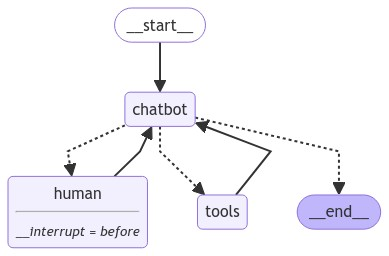

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Explaination/Interpretation:

The chat bot can either 

1. Request help from a human (chatbot->select->human)
2. Invoke the search engine tool (chatbot->select->action)
3. Directly respond (chatbot->select->end). 

Once an action or request has been made, the graph will transition back to the chatbot node to continue operations.

In [22]:
# Function to generate a unique session ID
import uuid

def generate_session_id() -> str:
    return str(uuid.uuid4())

In [24]:
# Generating a dynamic session ID
thread_id_1 = generate_session_id()
config_1 = {"configurable": {"thread_id": thread_id_1}}

In [25]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"

In [26]:
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config_1, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_LPHHMa5kKdDjzYC5ezbAkEGE)
 Call ID: call_LPHHMa5kKdDjzYC5ezbAkEGE
  Args:
    request: I need guidance on building an AI agent. Specifically, I'm looking for advice on the best practices, tools, and frameworks to use, as well as any potential challenges I might face during the development process.


### Notice: 

the LLM has invoked the "RequestAssistance" tool we provided it, and the interrupt has been set. 

Let's inspect the graph state to confirm.

In [27]:
snapshot = graph.get_state(config_1)
snapshot.next

('human',)

The graph state is indeed interrupted before the 'human' node. 

We can act as the "expert" in this scenario and manually update the state by adding a new ToolMessage with our input.

# Response to chatbot's request

Respond to the chatbot's request by:

1. Creating a ```ToolMessage``` with our response. This will be passed back to the ```chatbot```.
2. Calling ```update_state``` to manually update the graph state.

In [28]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

In [29]:
tool_message = create_response(human_response, ai_message)

In [30]:
graph.update_state(config_1, {"messages": [tool_message]})

{'configurable': {'thread_id': '1dab5e31-4902-49ac-bd98-50b4630f7b24',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6384f-0021-69e4-8002-871a125702cc'}}

We can inspect the state to confirm our response was added.

In [32]:
graph.get_state(config_1).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='e5d5b133-f5c1-45f6-b624-071f468e92eb'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LPHHMa5kKdDjzYC5ezbAkEGE', 'function': {'arguments': '{"request":"I need guidance on building an AI agent. Specifically, I\'m looking for advice on the best practices, tools, and frameworks to use, as well as any potential challenges I might face during the development process."}', 'name': 'RequestAssistance'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 55, 'prompt_tokens': 160, 'total_tokens': 215}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_48196bc67a', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c5a2c24f-b1c2-4257-988c-885b7d3fe461-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': "I need guidance on building an AI agent. Specifically, I'm looking for advice on the be

# Resume the graph:

Next, resume the graph by invoking it with ```None``` as the inputs.


In [33]:
events = graph.stream(None, config_1, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

I've reached out for expert guidance, and they recommend using **LangGraph** for building your AI agent. It's considered more reliable and extensible compared to simpler autonomous agents. If you need further assistance or have specific questions about LangGraph or the development process, feel free to ask!


# Summary:

Notice that the chat bot has incorporated the updated state in its final response. 

Since everything was checkpointed, the "expert" human in the loop could perform the update at any time without impacting the graph's execution.

We've now added an additional node to your assistant graph to let the chat bot decide for itself whether or not it needs to interrupt execution. 

We did so by updating the graph State with a new ```ask_human``` field and modifying the interruption logic when compiling the graph. 

This lets us dynamically include a human in the loop while maintaining full memory every time you execute the graph.
